In [10]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import os
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from scikeras.wrappers import KerasClassifier
from keras.applications.vgg16 import VGG16
import random 


In [11]:
def set_seeds(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    tf.experimental.numpy.random.seed(seed)

set_seeds()
images_dir = ("D:/Machine learning/Datasets/brain/brain_tumor_dataset")
yes_dir = os.path.join(images_dir,'yes')
no_dir = os.path.join(images_dir,'no')

def process(x,y):
    images, labels = [],[]
    for filename in os.listdir(x):
        img_y = cv2.imread(os.path.join(x,filename))
        img_y = cv2.resize(img_y,(256,256),interpolation=cv2.INTER_CUBIC)
        img_y = img_y / 255.0
        images.append(img_y)
        labels.append(1)

    for img in os.listdir(y):
        img_n = cv2.imread((os.path.join(y,img)))
        img_n = cv2.resize(img_n,(256,256),interpolation=cv2.INTER_CUBIC)
        img_n = img_n / 255.0
        images.append(img_n)
        labels.append(0)
   

    image_s = pd.Series(images, name='Image Arrays')
    label_s = pd.Series(labels, name='Labels')
    df = pd.DataFrame(pd.concat([image_s,label_s], axis=1))
    return df

df = process(yes_dir,no_dir)


(256, 256, 3)


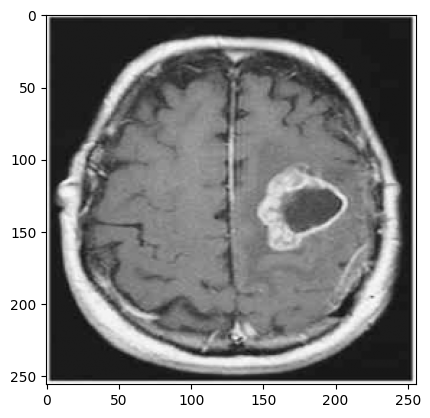

In [12]:
img_array = df.iloc[1,0]
print(img_array.shape)
plt.imshow(img_array)
plt.show()

In [13]:
datagen = ImageDataGenerator(
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    horizontal_flip = True,
    shear_range = 0.2,
    fill_mode='nearest',
)


In [20]:
X_train, X_test, Y_Train, Y_test = train_test_split(df,df['Labels'],test_size=0.2, random_state=42)
X_train, X_cv,Y_Train, Y_cv = train_test_split(X_train,Y_Train, test_size=0.25, random_state=42)
cv = X_cv["Labels"]
test = X_test['Labels']
train = X_train['Labels']
X_Train = X_train.drop(labels=['Labels'],axis=1)
X_Cv = X_cv.drop(labels=['Labels'],axis=1)
X_Test = X_test.drop(labels=['Labels'],axis=1)
X_Train_array = np.stack(X_Train['Image Arrays'].values)
X_Cv_array = np.stack(X_Cv['Image Arrays'].values)
X_Test_array = np.stack(X_Test['Image Arrays'].values)


In [25]:
print(X_Train_array.shape)
print(X_Cv_array.shape)
print(X_Test_array.shape)

(151, 256, 256, 3)
(51, 256, 256, 3)
(51, 256, 256, 3)


In [15]:
train_generator = datagen.flow(
    X_Train_array,
    train.values,
    batch_size=32,
    shuffle=True,
)

X_tr, Y_tr = next(train_generator)



In [24]:
early = keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0,patience=15, verbose=2, restore_best_weights=True, mode='auto')
earlyv2 = keras.callbacks.EarlyStopping(monitor='val_accuracy',min_delta=0.01, patience = 15, verbose=2, restore_best_weights=True, mode='auto')
rlronp=keras.callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor=0.5, patience=5,
                                             verbose=1,mode='auto')
check_scratch = keras.callbacks.ModelCheckpoint('secondary_model.keras', monitor='val_accuracy', save_best_only=True, mode='max')
vgg_2checl =  keras.callbacks.ModelCheckpoint('VGG2.0.keras', monitor='val_accuracy', save_best_only=True, mode='max')


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
model1 = VGG16(weights='imagenet', include_top=False, input_shape=(256,256,3))
def new_model(dropout,model1):
    for layer in model1.layers:
        layer.trainable = False
    x = model1.output
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(512, activation='relu')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(dropout)(x)
    x = keras.layers.Dense(512, activation='relu')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(dropout)(x)
    predictions = keras.layers.Dense(1, activation='sigmoid')(x)
    optimizers = keras.optimizers.Adam(learning_rate=0.00005)
    model = keras.Model(inputs = model1.input, outputs = predictions)
    model.compile(optimizer=optimizers,
              loss = 'binary_crossentropy',
              metrics=['accuracy'],
    )
    return model



dropout = [0.3,0.7,0.8]
model = KerasClassifier(build_fn = new_model,model1 = model1, verbose = 1,dropout=dropout)

param_grid = dict(dropout=dropout)
grid = GridSearchCV(estimator = model, param_grid = param_grid, verbose = 1)
grid_results = grid.fit(X_tr,Y_tr, validation_data=(X_Cv_array, cv))
print("Best: {0}, using {1}".format(grid_results.best_score_, grid_results.best_params_))
means = grid_results.cv_results_['mean_test_score']
for mean in zip(means):
    print('{0}'.format(mean))



In [7]:
def schedluler(epoch,lr):
    if epoch < 10:
        return lr
    else:
        return lr * 0.05
schedlule = keras.callbacks.LearningRateScheduler(schedluler)

In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256,256,3))
for layer in base_model.layers[:-5]:
    layer.trainable = False
x = base_model.output
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(512, activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.3)(x)
x = keras.layers.Dense(512, activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.5)(x)
predictions = keras.layers.Dense(1, activation='sigmoid')(x) 

model_final = keras.Model(inputs = base_model.input, outputs = predictions)
model_final.compile(optimizer=keras.optimizers.Adam(),
              loss = 'binary_crossentropy',
              metrics=['accuracy'],
)

his = model_final.fit(train_generator, epochs=40, batch_size=64,shuffle=True, validation_data=(X_Cv_array, cv), callbacks=[schedlule,vgg_2checl,rlronp])




In [22]:
Best_Model = keras.models.load_model('VGG2.0.keras')
loss, accuracy = Best_Model.evaluate(X_Cv_array,cv)
print('Cv Accuracy:', accuracy)


2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step - accuracy: 0.8460 - loss: 0.4105
Cv Accuracy: 0.8627451062202454


In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(his.history['accuracy'], label='Training Accuracy')
plt.plot(his.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [ ]:
learning_rate = [5e-6,5e-12,5e-15]
results =  {lr: [] for lr in learning_rate}
score = {lr: 0 for lr in learning_rate}
for values in learning_rate:
    print(f"Current Learning Rate: {values}")
    optimizers = keras.optimizers.Adam(learning_rate=values)
    model_final.compile(optimizer=optimizers,
              loss = 'binary_crossentropy',
              metrics=['accuracy'],
    )
    for epoch in range(10):
        his = model_final.fit(train_generator, epochs= 1, batch_size=32,validation_data=(X_Cv_array,cv), verbose=1)
        val_accuracy = his.history['val_accuracy'][0]
        results[values].append(val_accuracy)

        if val_accuracy > score[values]:
            score[values] = val_accuracy
           
        val_loss = his.history['val_loss'][0]
        print(f"Epoch: {epoch+1}/10 - Loss: {val_loss} - Accuracy: {val_accuracy}")

    valid_loss, valid_acc = model_final.evaluate(X_Cv_array, cv)
    print(f"Validation Accuracy: {valid_acc:.2f}")

    for lr, best_acc in score.items():
        print(f"Learning rate {values}: {best_acc:.2f}")
    
best_score = max(score, key=score.get)
print(f"Best validation Accuracy: {best_score:.2f}, with learning rate: {score[best_score]}")




In [ ]:
plt.figure(figsize=(12, 6))
for lr, acc in results.items():
    plt.plot(range(1,11), acc,label=f'Learning Rate: {lr}')
plt.title("Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(filters=64, 
                         kernel_size=3, 
                         activation="relu", 
                         input_shape=(256, 256, 3)), 
  tf.keras.layers.Conv2D(32, 3, activation="relu"),
  tf.keras.layers.MaxPool2D(pool_size=2, 
                            padding="valid"),
  tf.keras.layers.Conv2D(32, 3, activation="relu"),
  tf.keras.layers.Conv2D(32, 3, activation="relu"), 
  tf.keras.layers.MaxPool2D(2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(256, activation="relu"), 
  tf.keras.layers.Dense(128, activation="relu"), 
  tf.keras.layers.Dense(1, activation="sigmoid") 
])
model.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])
model_history = model.fit(train_generator, 
                        epochs=50,
                        steps_per_epoch=len(X_Train_array),
                        validation_data=(X_Cv_array,cv)
                        ,shuffle=True,
                        callbacks=[check_scratch])

In [19]:
secondary_model = keras.models.load_model('secondary_model.keras')
loss, acc = secondary_model.evaluate(X_Cv_array,cv)
print('Cv Accuracy:', acc)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 285ms/step - accuracy: 0.8068 - loss: 0.5906
Cv Accuracy: 0.8039215803146362
